## need to convert bedmachine v2 topography x,y coords in metres to lat/long
https://sites.uci.edu/morlighem/dataproducts/bedmachine-antarctica/

see also doc in /g/data/v45/pas561/bedmachineant/
The projection is Polar Stereographic South (71ºS, 0ºE), which corresponds to
ESPG 3031

In [1]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cartopy.crs as ccrs
import cmocean as cm
from collections import OrderedDict
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
import matplotlib.path as mpath

import cmocean.cm as cmocean
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pyproj import Proj, transform

In [2]:
client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:38611 Dashboard: /proxy/39625/status,Cluster Workers: 8 Cores: 8 Memory: 100.00 GiB


see also doc in /g/data/v45/pas561/bedmachineant/
All heights are referenced to mean sea level (using the geoid EIGEN-6C4). To convert the heights to heightsreferenced to the WGS84 ellipsoid, simply add the geoid height

In [25]:
bedbathy=xr.open_mfdataset('/g/data/v45/pas561/bedmachineant/BedMach*.nc',engine='netcdf4',decode_times=False)

In [26]:
#takes a long time to plot full file
bedbathy.bed.plot.pcolormesh()

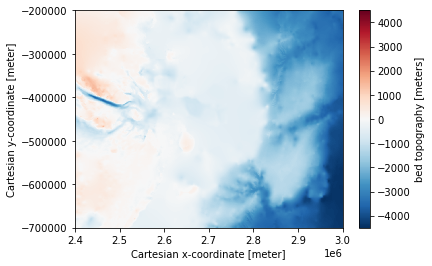

In [27]:
#plot denman region --- want this to be in lat/lon coords instead of metres
bedbathy.bed.sel(y=slice(-.2e6,-.7e6)).sel(x=slice(2.4e6,3e6)).plot.pcolormesh()

In [28]:
bedbathy

<xarray.Dataset>
Dimensions:    (x: 13333, y: 13333)
Coordinates:
  * x          (x) int32 -3333000 -3332500 -3332000 ... 3332000 3332500 3333000
  * y          (y) int32 3333000 3332500 3332000 ... -3332000 -3332500 -3333000
Data variables:
    mapping    |S1 ...
    mask       (y, x) int8 dask.array<chunksize=(13333, 13333), meta=np.ndarray>
    firn       (y, x) float32 dask.array<chunksize=(13333, 13333), meta=np.ndarray>
    surface    (y, x) float32 dask.array<chunksize=(13333, 13333), meta=np.ndarray>
    thickness  (y, x) float32 dask.array<chunksize=(13333, 13333), meta=np.ndarray>
    bed        (y, x) float32 dask.array<chunksize=(13333, 13333), meta=np.ndarray>
    errbed     (y, x) float32 dask.array<chunksize=(13333, 13333), meta=np.ndarray>
    source     (y, x) int8 dask.array<chunksize=(13333, 13333), meta=np.ndarray>
    geoid      (y, x) int16 dask.array<chunksize=(13333, 13333), meta=np.ndarray>
Attributes: (12/17)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     15-Jul-2020 (v2.0)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    ymax:                        3333000
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...

In [29]:
#from doc in /g/data/v45/pas561/bedmachineant/
#The projection is Polar Stereographic South (71ºS, 0ºE), which corresponds to
#ESPG 3031
inProj="epsg:3031"

#https://spatialreference.org/ref/epsg/wgs-84/
outProj="epsg:4326"

In [30]:
x2,y2 = transform(inProj,outProj,bedbathy.x.values,bedbathy.y.values)
#print(x2,y2)
print(np.min(x2),np.max(x2),np.min(y2),np.max(y2))

-90.0 -48.464383106398614 -45.0 135.0


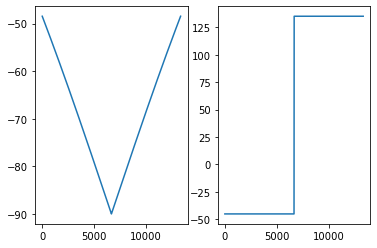

In [46]:
#the transformed coords are wrong
plt.subplot(1,2,1)
plt.plot(x2)
plt.subplot(1,2,2)
plt.plot(y2)

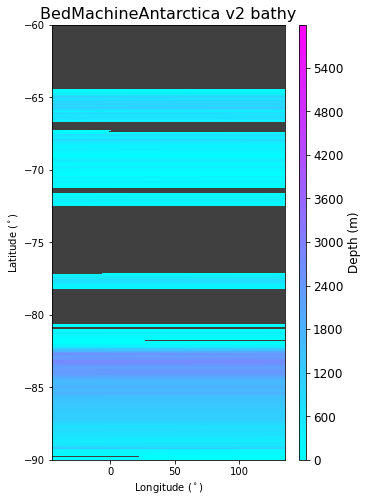

In [79]:
#plot using new lat lon coords .... 
clev = np.arange(0,6000,10)
clev2 = np.arange(0,6000,500)
fontsize=12

plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.gca().patch.set_color('.25')
p1=plt.contourf(x2,y2,bedbathy.bed,levels=clev,cmap=plt.cm.cool)
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=clev2,colors='k',linewidths=0.25)
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.ylim([-90,-60])
#plt.xlim([-270,-250])
plt.title('BedMachineAntarctica v2 bathy',fontsize = 16)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Depth (m)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)